# Naive method, $e^+e^-\rightarrow\eta\pi^+\pi^-$ (2)
This notebook is similar to notebook [naive_method_etapipi_1.ipynb](./naive_method_etapipi_1.ipynb), but non-trivial detection efficiency is used. The detection efficiency in this case is
$$
\varepsilon(x, s) =
\begin{cases}
1, & \sqrt{s}-\sqrt{s(1 - x}<10\text{ MeV},\\
0, & \text{otherwise}.
\end{cases}
$$
This efficiency is purely model, i.e. does not correspond to real experiment.

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
from PyISR import ISRSolverSLE
from ROOT import TFile
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                                          'Lucida Grande', 'Verdana']

Welcome to JupyROOT 6.24/02


Remove scrolling:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

Loading the model Born cross section

In [4]:
# Opening the file containing the model cross section
fl = TFile.Open('data/born_cs_etapipi_simple_model.root', 'read')
# Cloning the model cross section function
mBCsFcn = fl.Get('f_bcs').Clone()
# Vectorizing the model Born cross section function
mBCsVFcn = np.vectorize(lambda en: mBCsFcn.Eval(en))
# Closing the file
fl.Close()

Saving the current Matplotlib style:

In [5]:
# Current Matplotlib style parameters
mplStyleParams = dict(matplotlib.rcParams)
# Deprecated parameters
deprecatedParams = ['animation.avconv_args', 'animation.avconv_path', 
                    'animation.html_args', 'keymap.all_axes',
                   'savefig.jpeg_quality', 'text.latex.preview']
# Remove deprecated parameters in oder to avoid warnings
_ = list(map(lambda key : mplStyleParams.pop(key, None), deprecatedParams))

Function for reading visible cross section data:

In [6]:
def readVCS(path):
    fl = TFile.Open(path, "read")
    # Getting a pointer to the visible cross section in the form of TGraphErrors
    gvcs = fl.Get('vcs')
    # Number of c.m. energy points
    n = gvcs.GetN()
    # Reading c.m. energy array
    energy = np.frombuffer(gvcs.GetX(), dtype=np.float64, count=n)
    # Reading array of c.m. energy errors
    energyErr = np.frombuffer(gvcs.GetEX(), dtype=np.float64, count=n)
    # Reading visible cross section array
    vcs = np.frombuffer(gvcs.GetY(), dtype=np.float64, count=n)
    # Reading array of visible cross section errors
    vcsErr = np.frombuffer(gvcs.GetEY(), dtype=np.float64, count=n)
    fl.Close()
    return energy, vcs, energyErr, vcsErr

Function for obtaining numerical solution:

In [7]:
def solve(energy, vcs, energyErr, vcsErr, 
          enabled_energy_spread=False, 
          threshold_energy=0.827, 
          interp=None,
          efficiency=lambda x, en: 1.0):
    n = energy.shape[0]
    solver = ISRSolverSLE(n, energy, vcs, 
                          energyErr, vcsErr, 
                          threshold_energy, efficiency,
                          enabled_energy_spread)
    if type(interp) == str:
        with open(interp, 'r') as jfl:
            settings = json.load(jfl)
        
        print('Interpolation settings:')
        print(settings)
        solver.set_interp_settings(settings)
    elif type(interp) == list:
        print('Interpolation settings:')
        print(interp)
        solver.set_interp_settings(interp)
    
    solver.solve()
    return solver

Function for cross section plotting:

In [8]:
def csPlot(solver, title='Cross sections', fontsize=24):
    # Getting c.m. energy array
    ecm = solver.ecm()
    matplotlib.rcParams.update(mplStyleParams)
    f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True,
                                figsize=(9, 10))
    f.suptitle(title, fontsize=fontsize)
    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ecm_dense = np.linspace(np.min(ecm), np.max(ecm), ecm.shape[0] * 20)
    interp = np.vectorize(lambda en: solver.interp_eval(en))(ecm_dense)
    ax0.errorbar(ecm, solver.vcs(), 
                xerr=solver.ecm_err(),
                yerr=solver.vcs_err(), fmt='o',
                markersize=5, capsize=3,
                label='Visible cross section', zorder=0)
    bcs_err = yerr=np.sqrt(np.diag(solver.bcs_cov_matrix()))
    ax0.errorbar(ecm, solver.bcs(), yerr=bcs_err, fmt='o',
                 markersize=5, capsize=3,
                label='Born cross section', zorder=1)
    ax0.plot(ecm_dense, interp, 'b--', label='Interpolation of the Born cross section', zorder=2)
    ax0.plot(ecm_dense, mBCsVFcn(ecm_dense), 'r-', label='Model Born cross section', zorder=3)
    mBCs_at_ecm =  mBCsVFcn(ecm)
    ax1.errorbar(ecm, solver.bcs() / mBCs_at_ecm, yerr=bcs_err / mBCs_at_ecm, fmt='o',
                 markersize=5, capsize=3,
                 label=r'Ratio $\frac{\sigma_{\rm B}}{\sigma^{\rm model}_{\rm B}}$',
            zorder=0)
    ax1.set_xlabel(r'$\sqrt{s}$ (GeV)', fontsize=fontsize)
    ax0.set_ylabel('cross section (nb)', fontsize=fontsize)
    ax0.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 1))

Function for plotting matrices:

In [9]:
def matrixPlot(mx, title='', fontsize=24, fontscale=2.0):
    sns.set(font_scale=fontscale)
    f, ax = plt.subplots(figsize=(9, 7))
    f.suptitle(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    sns.heatmap(mx, ax=ax, square=True)

In [10]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_no_energy_spread_efficiency10MeV.root'
fl = TFile.Open(input_path, 'read')
eff_data = fl.Get('efficiency').Clone()
fl.Close()

In [11]:
def eval_eff(x, ecm):
    tbin = eff_data.FindFixBin(x, ecm)
    return eff_data.GetEfficiency(tbin)

In [12]:
vx = np.linspace(0, 0.03, 1000)
vecm = np.linspace(1.18, 2.0, 1000)
mx = np.array([])
mecm = np.array([])
meff = np.array([])

In [13]:
effVFcn = np.vectorize(lambda x, ecm: eval_eff(x, ecm))
for x in vx:
    meff = np.hstack((meff, effVFcn(x, vecm)))
    mecm = np.hstack((mecm, vecm))
    mx = np.hstack((mx, x * np.ones(vecm.shape)))
    
q = pd.DataFrame.from_dict(np.array([mx,mecm,meff]).T)
q.columns = ['x', 'en', 'eff']
q['x'] = pd.to_numeric(q['x'])
q['en'] = pd.to_numeric(q['en'])
q['eff'] = pd.to_numeric(q['eff'])

In [14]:
eff_xymap = q.pivot_table(index='x', columns='en', values='eff')
eff_xymap

en,1.180000,1.180821,1.181642,1.182462,1.183283,1.184104,1.184925,1.185746,1.186567,1.187387,...,1.992613,1.993433,1.994254,1.995075,1.995896,1.996717,1.997538,1.998358,1.999179,2.000000
x,,,,,,,,,,,,,,,,,,,,,
0.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0.00003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0.00006,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0.00009,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0.00012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.02988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


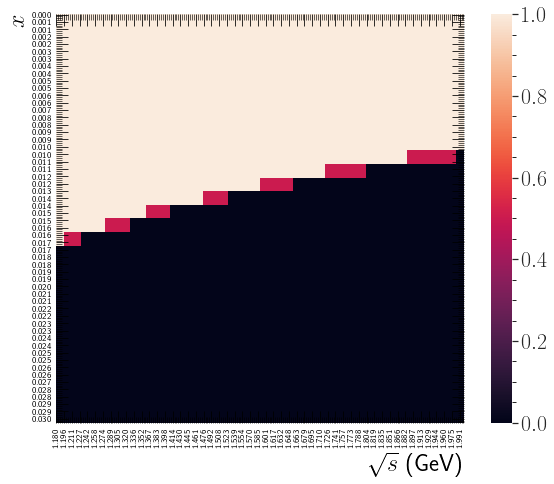

In [15]:
f, ax = plt.subplots(figsize=(10, 9))
fontsize=24
sns.set(font_scale=2)
plot = sns.heatmap(eff_xymap, rasterized=True, square=True, ax=ax)
ax.set_xticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])
ax.set_yticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])
ax.set_xlabel(r'$\sqrt{s}$ (GeV)', fontsize=fontsize)
ax.set_ylabel(r'$x$', fontsize=fontsize)
plt.gcf().subplots_adjust(left=0.15, bottom=0.25)

## No c.m. energy spread: $\sigma_E(s)=0\text{ MeV}$, piecewise linear interpolation

Condition number: 1.1522596983690971


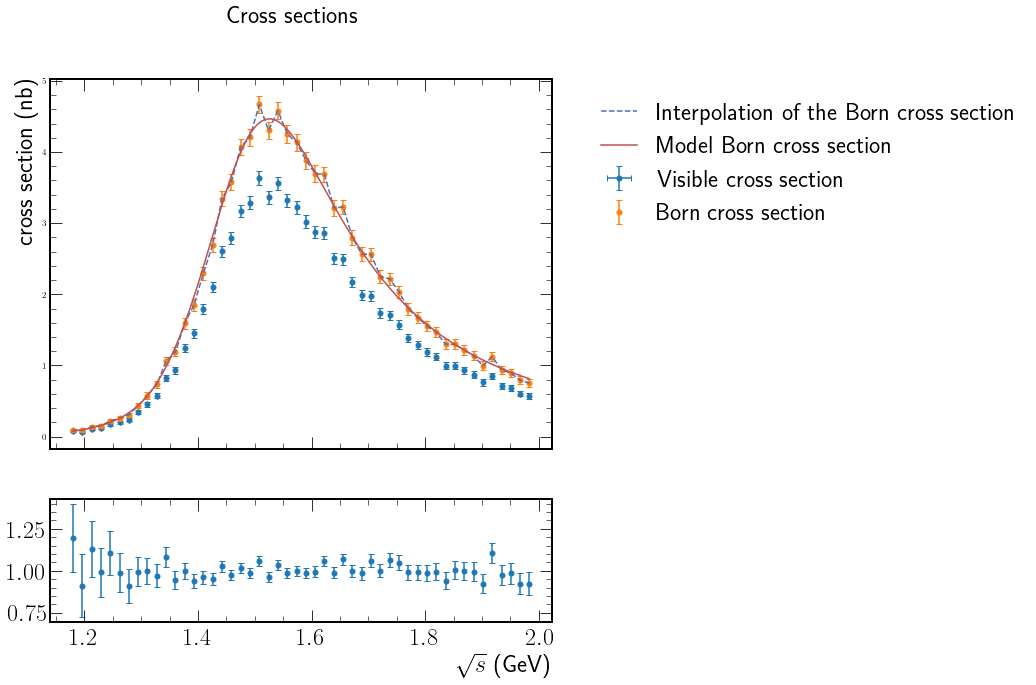

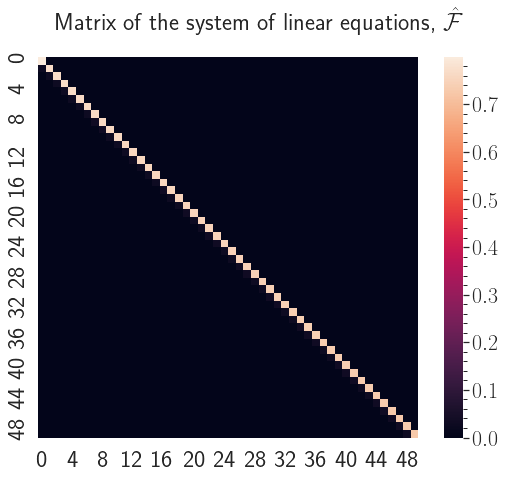

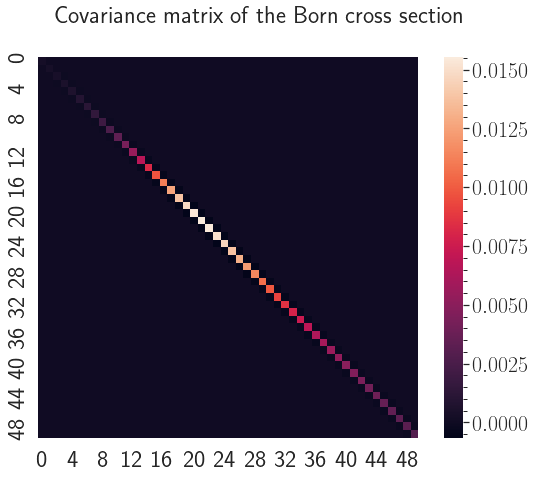

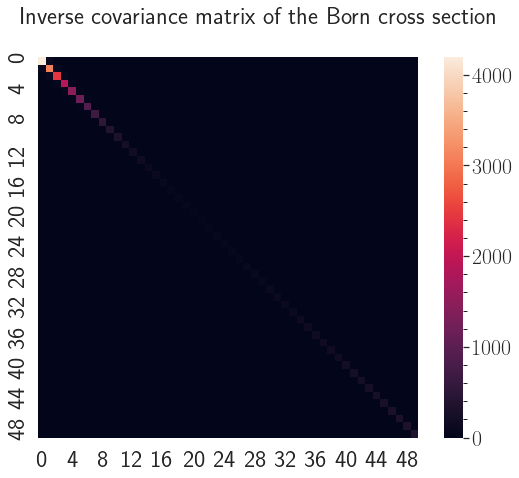

In [16]:
solver = solve(*readVCS(input_path), efficiency=eval_eff)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')
matrixPlot(solver.bcs_inv_cov_matrix(), title=r'Inverse covariance matrix of the Born cross section')